This file is to test my model on the TUH-EEG-seizure data

Now my model is a VAR(k) model, where k is a move step.

I do not use the SC layer. 

X_t+k = exp(A_t k*dlt)X_t for k =1, ldots, KX_t+k = exp(A_t k*dlt)X_t for k =1, ldots, K

In [1]:
RUN_PYTHON_SCRIPT = False
MODEL_NAME = "mstep_dlt"
SAVED_MODEL = None
#SAVED_MODEL = "lay2_VARk_epoch1"

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
import time

if not RUN_PYTHON_SCRIPT:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
import importlib
import data_utils.eeg_load
importlib.reload(data_utils.eeg_load)

<module 'data_utils.eeg_load' from '/data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/data_utils/eeg_load.py'>

In [15]:
from models.my_main_model import myNet
from models.model_utils import generate_position_encode
from models.netout2pred_fns import netout2loss_tvdn
from data_utils.eeg_load import EEG_data, MyDataLoader
from utils.misc import delta_time, load_pkl_folder2dict, save_pkl_dict2folder, truncated_mean_upper

In [6]:
# pkgs for pytorch (on Apr 3, 2023)
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda")
else:
    torch.set_default_tensor_type(torch.DoubleTensor)
    device = torch.device("cpu")

# training

In [8]:
if SAVED_MODEL is None:
    config = edict()
    config.nfeature = 19 # the dim of features at each time point
    config.ndim = 256 # the output of the first FC layer
    config.dropout = 0 # the dropout rate
    config.n_layer = 1 # the number of self-attention layers
    config.n_head = 8 # numher of heads for multi-head attention
    config.is_mask = True # Use mask to make the attention causal
    config.is_bias = True # Bias  for layernorm
    config.block_size = 256 # the preset length of seq, 
    config.batch_size = 2 # the batch size
    config.move_step = 32 # k, movestep
    config.fs = 90
    config.num_Bs = 45 # no use now (on May 9, 2023)
    config.target_dim = 19**2
    
    paras_train = edict()
    paras_train.nepoch= 2
    paras_train.loss_out = 10
    paras_train.clip = 1 # 
    paras_train.lr_step = 300
    paras_train.test_loss_out = 50
else:
    saved_model_path = RES_ROOT/SAVED_MODEL
    assert saved_model_path.exists(), "No such model"
    saved_model = load_pkl_folder2dict(saved_model_path)
    
    config = saved_model.config
    paras_train = saved_model.paras_train

In [9]:
def trans_batch(batch):
    """transform the batch to make it easy for training
    """
    batch = batch * 1e6
    X, Y = batch[:, :config.block_size], batch[:, 1:]
    Y_move = batch[:, :-1] # use X_t as prediction of X_t+1
    return X, Y, Y_move


def trun_MSE_loss(Y, Y_pred, quantile=0.5):
    loss_fn1 = nn.MSELoss(reduction='none')
    ls = loss_fn1(Y, Y_pred)
    qv = torch.quantile(ls, quantile)
    loss_v = ls[ls < qv].mean()
    return loss_v

In [10]:
train_data = EEG_data("train_train", "AR", 
                      move_dict=dict(winsize=config.block_size+config.move_step,
                                     stepsize=config.block_size+config.move_step,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False)
                     )
test_data = EEG_data("train_test", "AR", 
                      move_dict=dict(winsize=config.block_size+config.move_step,
                                     stepsize=config.block_size+config.move_step,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False)
                    )

train_data_loader = MyDataLoader(train_data, batch_size=config.batch_size, shuffle=True)
test_data_loader = MyDataLoader(test_data, batch_size=4, shuffle=False)
print(len(train_data_loader), len(test_data_loader))

290300 12381


In [11]:
pos_enc = generate_position_encode(config.block_size, config.nfeature).unsqueeze(0)
loss_fn = nn.HuberLoss()
if SAVED_MODEL is None:
    net = myNet(config)
else:
    net = saved_model.model
    if torch.cuda.is_available():
        net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.1, verbose=True)

number of parameters: 0.89M
Adjusting learning rate of group 0 to 1.0000e-04.


In [16]:
def evaluate(net):
    sub_idxs = torch.randint(low=0, high=len(test_data_loader), size=(32, ))
    losses = []
    losses_base = []
    for sub_idx in sub_idxs:
        batch_test = test_data_loader(sub_idx.item())
        X_test, Y_test, Y_test_move = trans_batch(batch_test)
        X_testp = X_test + pos_enc;
        net.eval()
        with torch.no_grad():
            netout = net(X_testp)
            loss = netout2loss_tvdn(netout, X_test, Y_test, loss_fn, config, num_seg=None)
            loss_base = loss_fn(Y_test, Y_test_move)
        losses.append(loss.item())
        losses_base.append(loss_base.item())
    net.train()
    return np.median(losses), np.median(losses_base)

# training
loss_cur = []
loss_base_cur = []
if SAVED_MODEL is None:
    losses = []
    losses_test = []
else:
    losses = saved_model.losses
    losses_test = saved_model.losses_test

t0 = time.time()
for iep in range(paras_train.nepoch):
    train_data_loader = MyDataLoader(train_data, batch_size=config.batch_size, shuffle=True)
    for ix in range(len(train_data_loader)):
        batch = train_data_loader(ix)
        X, Y, Y_move = trans_batch(batch)
        Xp = X + pos_enc
        # Zero the gradients
        optimizer.zero_grad()
        
        netout = net(Xp)
        loss = netout2loss_tvdn(netout, X, Y, loss_fn, config, num_seg=None)
        loss_base = loss_fn(Y, Y_move)
        
        # Perform backward pass
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(net.parameters(), paras_train.clip)
        # Perform optimization
        optimizer.step()
        
        loss_cur.append(loss.item())
        loss_base_cur.append(loss_base.item())
        if ix % paras_train.loss_out == (paras_train.loss_out-1):
            losses.append(np.median(loss_cur))
            print(f"At iter {ix+1}/{len(train_data_loader)}, epoch {iep+1}, "
                  f"the losses are {losses[-1]:.3f} (train). "
                  f"the base losses are {np.median(loss_base_cur):.3f} (train). "
                  f"The time used is {delta_time(t0):.3f}s. "
                 )
            loss_cur = []
            loss_base_cur = []
            t0 = time.time()
            
        if ix % paras_train.test_loss_out == (paras_train.test_loss_out-1):
            test_loss = evaluate(net)
            losses_test.append(test_loss[0])
            print(f"At iter {ix+1}/{len(train_data_loader)}, epoch {iep+1}, "
                  f"the losses are {losses_test[-1]:.3f} (test). "
                  f"the base losses are {test_loss[1]:.3f} (test). "
                 )
        
    #if ix % paras_train.lr_step == (paras_train.lr_step-1):
    scheduler.step()
    
    # save the model 
    model_res = edict()
    model_res.model = net.cpu()
    model_res.config = config
    model_res.loss_fn = loss_fn
    model_res.losses = losses
    model_res.losses_test = losses_test
    model_res.paras_train = paras_train
    
    if SAVED_MODEL is None:
        cur_model_name = f"{MODEL_NAME}_epoch{iep+1}"
    else:
        cur_model_name = f"{MODEL_NAME}_epoch{iep+1}_w_{SAVED_MODEL}"
    save_pkl_dict2folder(RES_ROOT/cur_model_name, model_res, is_force=True)
    net.cuda()

At iter 10/290300, epoch 1, the losses are 10.050 (train). the base losses are 3.538 (train). The time used is 13.647s. 
At iter 20/290300, epoch 1, the losses are 13.412 (train). the base losses are 4.357 (train). The time used is 25.267s. 
At iter 30/290300, epoch 1, the losses are 8.700 (train). the base losses are 2.111 (train). The time used is 17.784s. 


KeyboardInterrupt: 

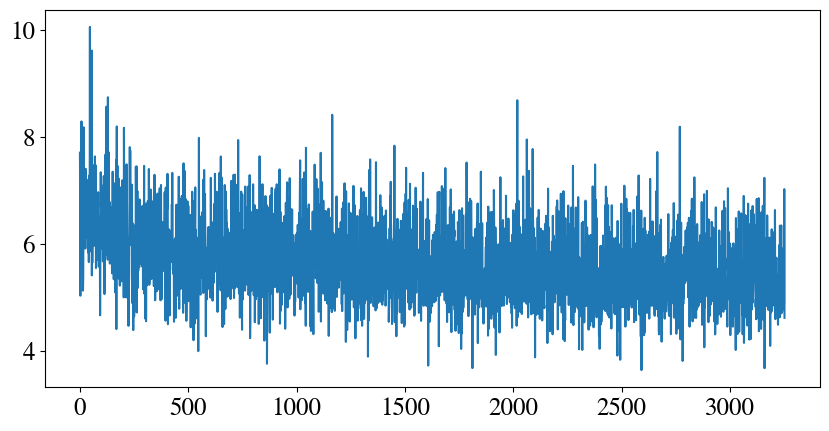

In [40]:
if not RUN_PYTHON_SCRIPT:
    #plt.plot(losses)
    plt.plot(losses_test)
    #plt.yscale("log")